# Econ 126 Winter 2020 Final Exam

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import linearsolve as ls
# import statsmodels.api as sm
import fredpy as fp

plt.style.use('classic')
%matplotlib inline

## Question 1 (a) 

I use the `fredpy` Python module to download data from FRED. Documentation for how to use `fredpy` available here: https://www.briancjenkins.com/fredpy/docs/build/html/index.html. Alternatively, the data could have been downloaded directly using `pd.read_csv()`.

In [2]:
# Download GDP data
gdp = fp.series('gdp')

# Download government purchases
gov = fp.series('GCE')

# Store government purchases-to-GDP ratio as 'y_ratio' and print value
gy_ratio = np.mean(gov.data/gdp.data)
print('G/Y:',round(gy_ratio,5))

G/Y: 0.20555


## Question 1 (b) 

In [3]:
# Create variables storing parameter values
beta = 0.99
alpha = 0.35
delta = 0.025
rhoA = .75
sigmaA = 0.006
rhoG = 0.9
sigmaG = 0.015

# Compute the steady state equilibrium directly
A = 1
K = (alpha*A/(beta**-1+delta-1))**(1/(1-alpha))
Y = A*K**alpha
I = delta*K

print('A:',round(A,5))
print('K:',round(K,5))
print('Y:',round(Y,5))
print('I:',round(I,5))

A: 1
K: 34.39823
Y: 3.44975
I: 0.85996


## Question 1(c)

In [4]:
# Compute steady state G, T, C
G = gy_ratio*Y


T = G
C = Y - I - G

print('G:',round(T,5))
print('C:',round(C,5))
print('T:',round(T,5))

G: 0.70911
C: 1.88068
T: 0.70911


## Question 1(d)

In [5]:
# Store parameter values in a Pandas Series called 'parameters'
parameters = pd.Series()
parameters['beta'] = beta
parameters['alpha'] = alpha
parameters['delta'] = delta
parameters['rhoA'] = rhoA
parameters['sigmaA'] = sigmaA
parameters['rhoG'] = rhoG
parameters['sigmaG'] = sigmaG
parameters['Gss'] = G

# Define a function that evaluates the equilibrium conditions
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
        
    # Resource constraint
    resource =  cur.y - cur.g - cur.i - cur.c
    
    # Exogenous tfp
    tfp_process = p.rhoA*np.log(cur.a) - np.log(fwd.a)
    
    # Exogenous gov consumption
    gov_process = (1-p.rhoG)*np.log(p.Gss) + p.rhoG*np.log(cur.g) - np.log(fwd.g)
    
    # Euler equation (capital)
    euler_capital = p.beta*(p.alpha*fwd.a*fwd.k**(p.alpha-1) + 1 - p.delta)/fwd.c - 1/cur.c
    
    # Government budget
    government_budget = cur.g - cur.t
    
    # Production
    production = cur.a*cur.k**p.alpha - cur.y
    
    # Capital evoluation
    capital_evolution = cur.i + (1-p.delta)*cur.k - fwd.k
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        resource,
        tfp_process,
        gov_process,
        euler_capital,
        government_budget,
        production,
        capital_evolution
        ])

# Initialize the model
model = ls.model(equations = equilibrium_equations,
                 n_states=3,
                 var_names=['a','g','k','c','y','i','t'],   # Any order as long as the state variables are named first
                 shock_names=['eA','eG','eK'],              # Name a shock for each state variable *even if there is no corresponding shock in the model*
                 parameters = parameters)

# Set steady state for linearsolve model
guess = [A,G,K,C,Y,I,T]
model.compute_ss(guess)

# Approximate and solve the model
model.approximate_and_solve()

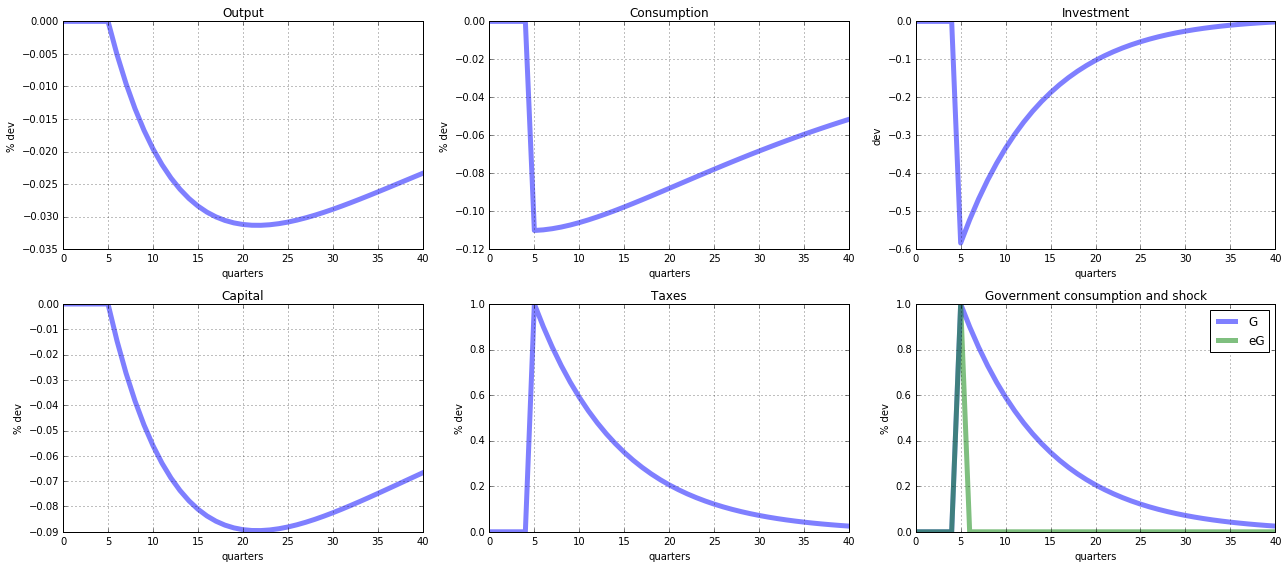

In [6]:
# Compute impulse responses
model.impulse(T=41,t0=5,shocks=[0,0.01,1],percent=True)

# Plot the computed impulse responses to a tax shock
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(2,3,1)
ax1.plot(model.irs['eG'][['y']],lw=5,alpha=0.5)
ax1.set_title('Output')
ax1.set_ylabel('% dev')
ax1.set_xlabel('quarters')
ax1.grid()

ax2 = fig.add_subplot(2,3,2)
ax2.plot(model.irs['eG'][['c']],lw=5,alpha=0.5)
ax2.set_title('Consumption')
ax2.set_ylabel('% dev')
ax2.set_xlabel('quarters')
ax2.grid()

ax3 = fig.add_subplot(2,3,3)
ax3.plot(model.irs['eG'][['i']],lw=5,alpha=0.5)
ax3.set_title('Investment')
ax3.set_ylabel('dev')
ax3.set_xlabel('quarters')
ax3.grid()

ax4 = fig.add_subplot(2,3,4)
ax4.plot(model.irs['eG'][['k']],lw=5,alpha=0.5)
ax4.set_title('Capital')
ax4.set_ylabel('% dev')
ax4.set_xlabel('quarters')
ax4.grid()

ax5 = fig.add_subplot(2,3,5)
ax5.plot(model.irs['eG'][['t']],lw=5,alpha=0.5)
ax5.set_title('Taxes')
ax5.set_ylabel('% dev')
ax5.set_xlabel('quarters')
ax5.grid()

ax6 = fig.add_subplot(2,3,6)
ax6.plot(model.irs['eG'][['g']],lw=5,alpha=0.5,label='G')
ax6.plot(model.irs['eG'][['eG']],lw=5,alpha=0.5,label='eG')
ax6.set_title('Government consumption and shock')
ax6.set_ylabel('% dev')
ax6.set_xlabel('quarters')
ax6.grid()
ax6.legend()

fig.tight_layout()

fig.savefig('fig_irs.png',dpi=120)